<a href="https://colab.research.google.com/github/karmanandan/similar-images-model/blob/main/SimilarImages_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Problem statement:*

**Find N similar images on a given Query image**

**Importing data**

In [1]:
# !wget --header="Host: doc-10-1c-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, 

In [2]:
# unzip the dataset folder
# !unzip dataset.zip

**Importing required libraries**

In [3]:
import os
import time
import random
import pickle
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm.notebook import tqdm
from sklearn.neighbors import NearestNeighbors


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

In [4]:
# getting files count from folder

In [5]:
SAMPLE_IMAGES = 4000

In [6]:
def get_all_files(root_dir):
    files_list = []
    counter = 1
    for root,directories,file_names in os.walk(root_dir):
        for file_name in file_names[:SAMPLE_IMAGES]:
            files_list.append(os.path.join(root,file_name))
            counter += 1
        break
    return files_list 

In [7]:
root_dir = '/content/drive/MyDrive/dataset'
file_names = get_all_files(root_dir)

In [8]:
print('Files count:',len(os.listdir(root_dir)))

Files count: 4740


In [9]:
# taking sample 4000 images from 4740

In [10]:
def fearure_extraction(img,model):
    img = image.load_img(img,target_size=(224,224))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array,axis=0)
    img_processed = preprocess_input(img_batch)
    features = model.predict(img_processed)
    features_flatten = features.flatten()
    normalized_features = features_flatten / np.linalg.norm(features_flatten)
    return normalized_features

In [11]:
# loading pre-trained model, using imagenet weights

In [12]:
model = ResNet50(include_top=False,input_shape=(224,224,3),weights='imagenet')

In [13]:
feature_list = []
for file_name in tqdm(file_names,total=len(file_names)):
    feature_list.append(fearure_extraction(file_name,model))

  0%|          | 0/4000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


In [14]:
neighbors_model = NearestNeighbors(n_neighbors=5, algorithm='brute',metric='euclidean').fit(feature_list)

In [15]:
def plot_similar_images(image_path,distances):
    og_image_path = mpimg.imread(image_path[0])
    similar_images = []    
    similar_images.append(og_image_path)
    for path in image_path[1]:
        similar_images.append(mpimg.imread(path))
    plt.figure(figsize=(30,15))
    columns = 5
    for i , image in enumerate(similar_images):
        ax = plt.subplot(1,columns,i+1)
        if i==0:
            ax.set_title('Query Image')
        else:
            ax.set_title(f'Similar Image : #{i} || Distance : {distances[i]:.2f}')
        plt.imshow(image)
        plt.axis('off')

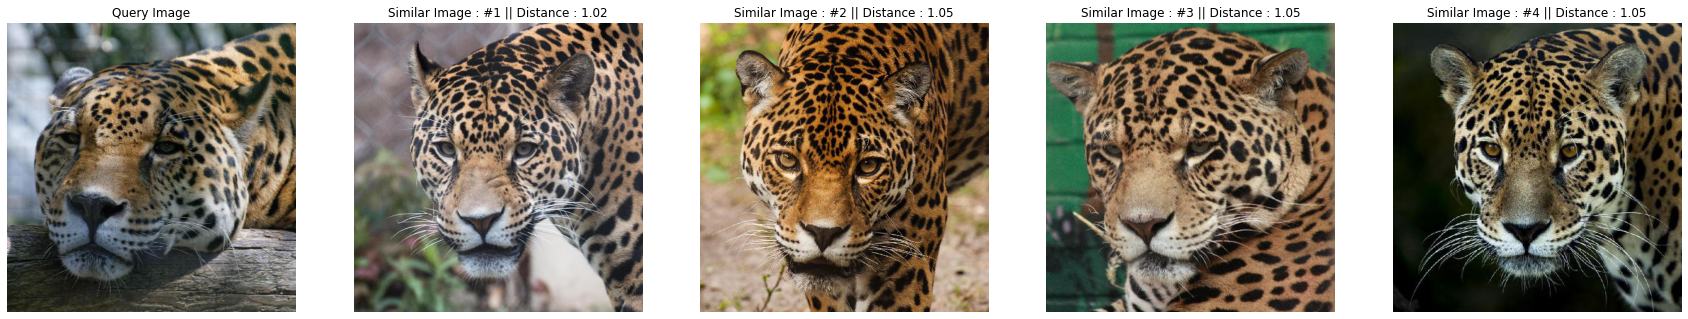

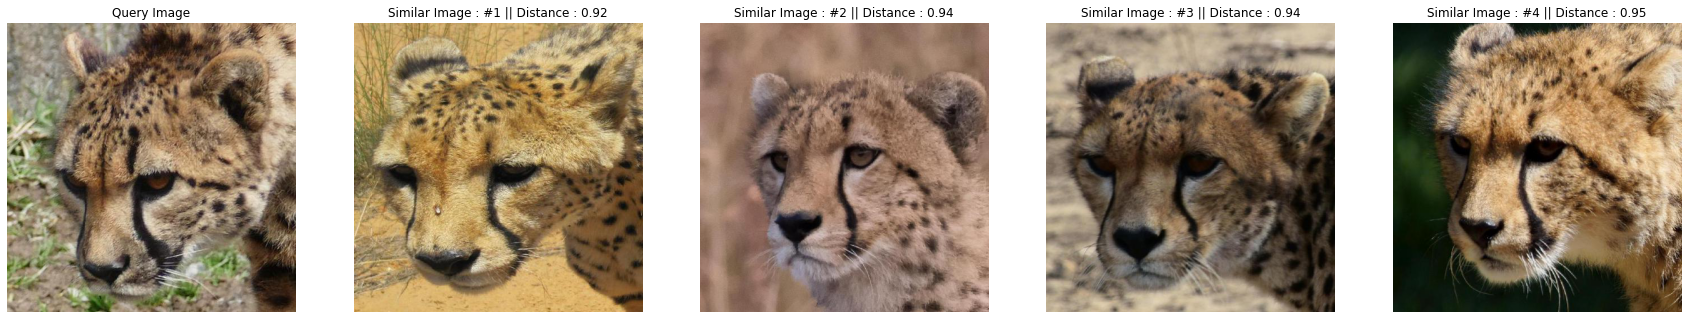

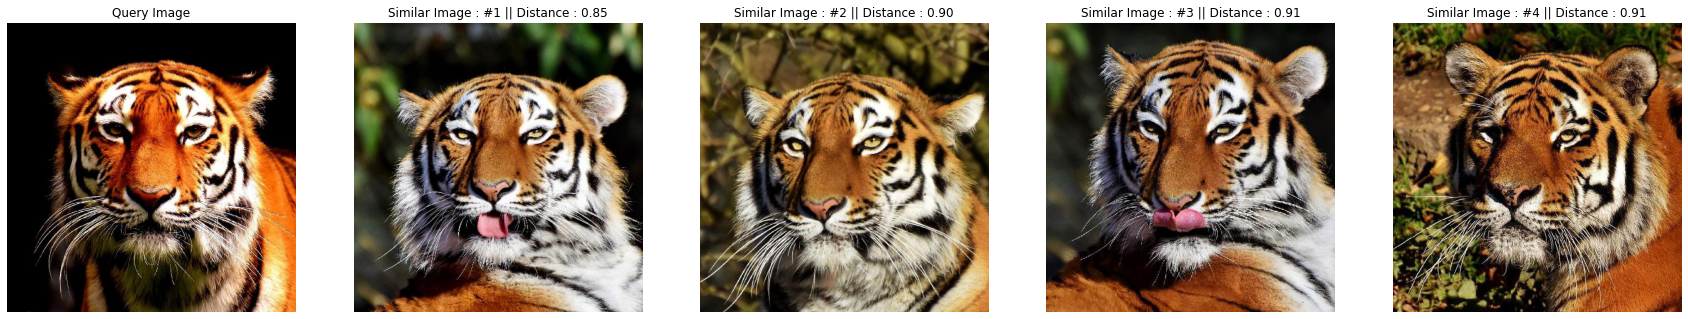

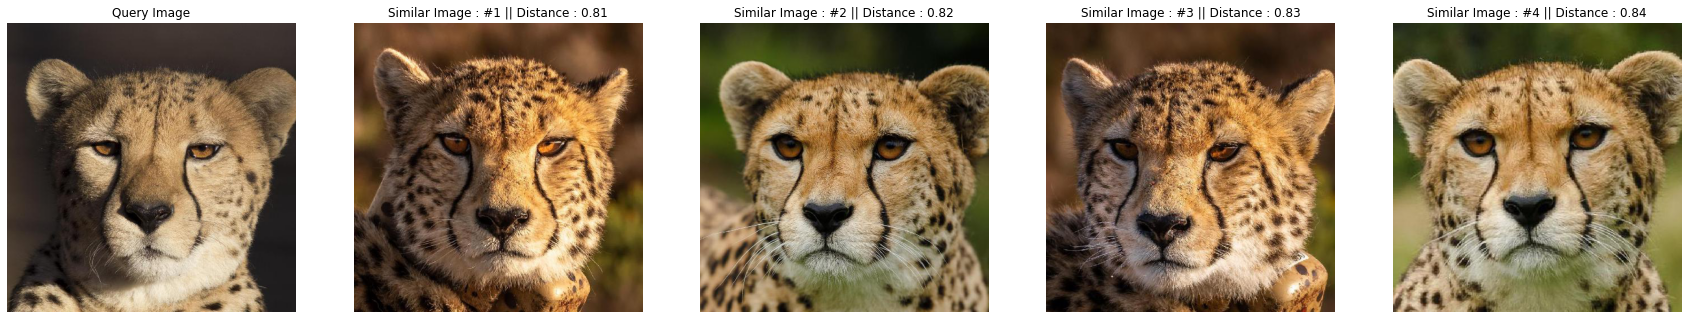

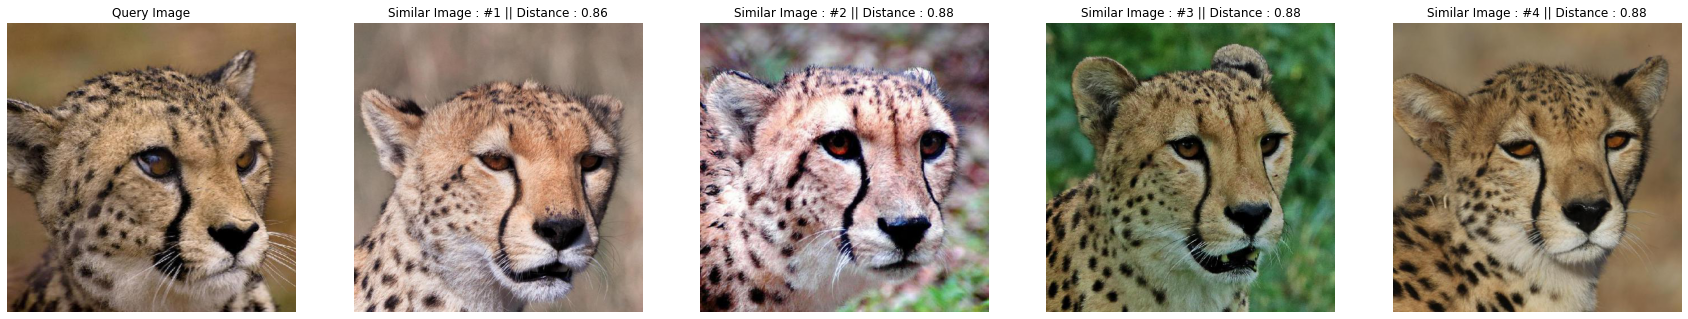

In [16]:
for i in range(5):
    random_image_index = random.randint(0,SAMPLE_IMAGES)
    distance, indices = neighbors_model.kneighbors(
                                [feature_list[random_image_index]])
    image_path = (file_names[random_image_index],
                                [file_names[indices[0][j]] for j in range(1,5)])
    plot_similar_images(image_path,distance[0])

In [17]:
# compress into lower dimension

In [18]:
num_feature_dimensions=100

pca = PCA(n_components = num_feature_dimensions)
pca.fit(feature_list[:500])

feature_list_compressed = pca.transform(feature_list[:500])

selected_features = feature_list_compressed
selected_filenames = file_names[:500]

tsne_results = TSNE(n_components=2,
                    verbose=1,
                    metric='euclidean',
                    init='pca',
                    learning_rate='auto').fit_transform(selected_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.259378


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.472595
[t-SNE] KL divergence after 1000 iterations: 0.513837


In [25]:
def plot_images_in_2d_format(x, y, image_paths, axis=None, zoom=1):
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        image = Image.open(image_path)
        image.thumbnail((100, 100), Image.LANCZOS)
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()

In [30]:
def show_tsne_format(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(15, 15, forward=True)
    plot_images_in_2d_format(x, y, selected_filenames, zoom=0.5, axis=axis)
    plt.show()

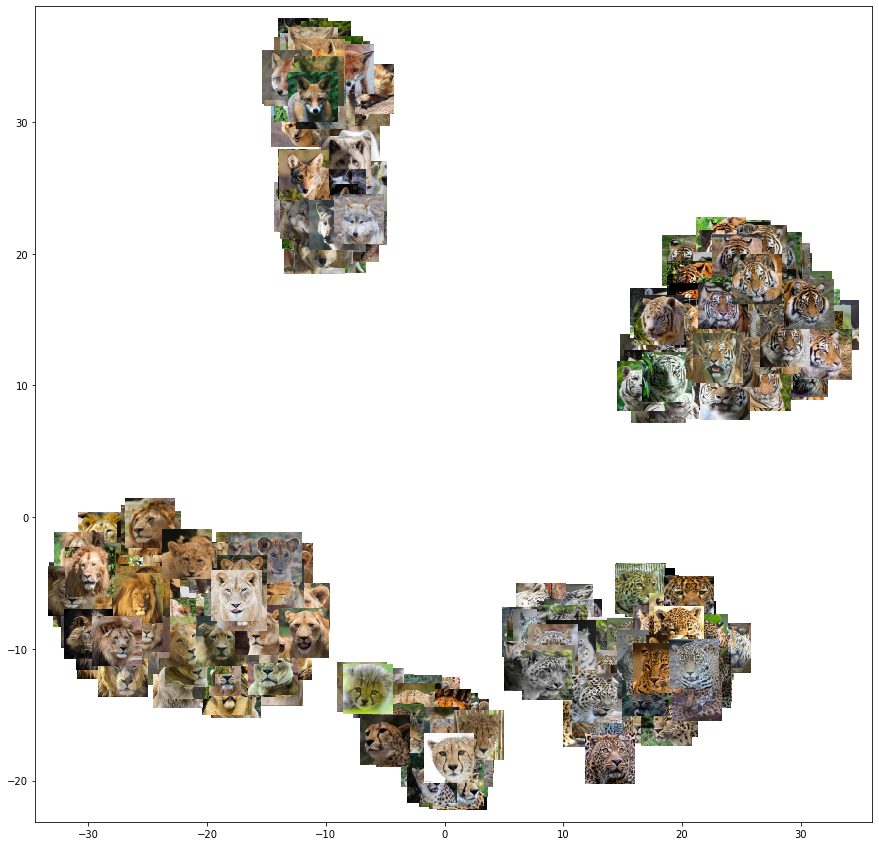

In [31]:
show_tsne_format(tsne_results[:, 0], tsne_results[:, 1], selected_filenames)

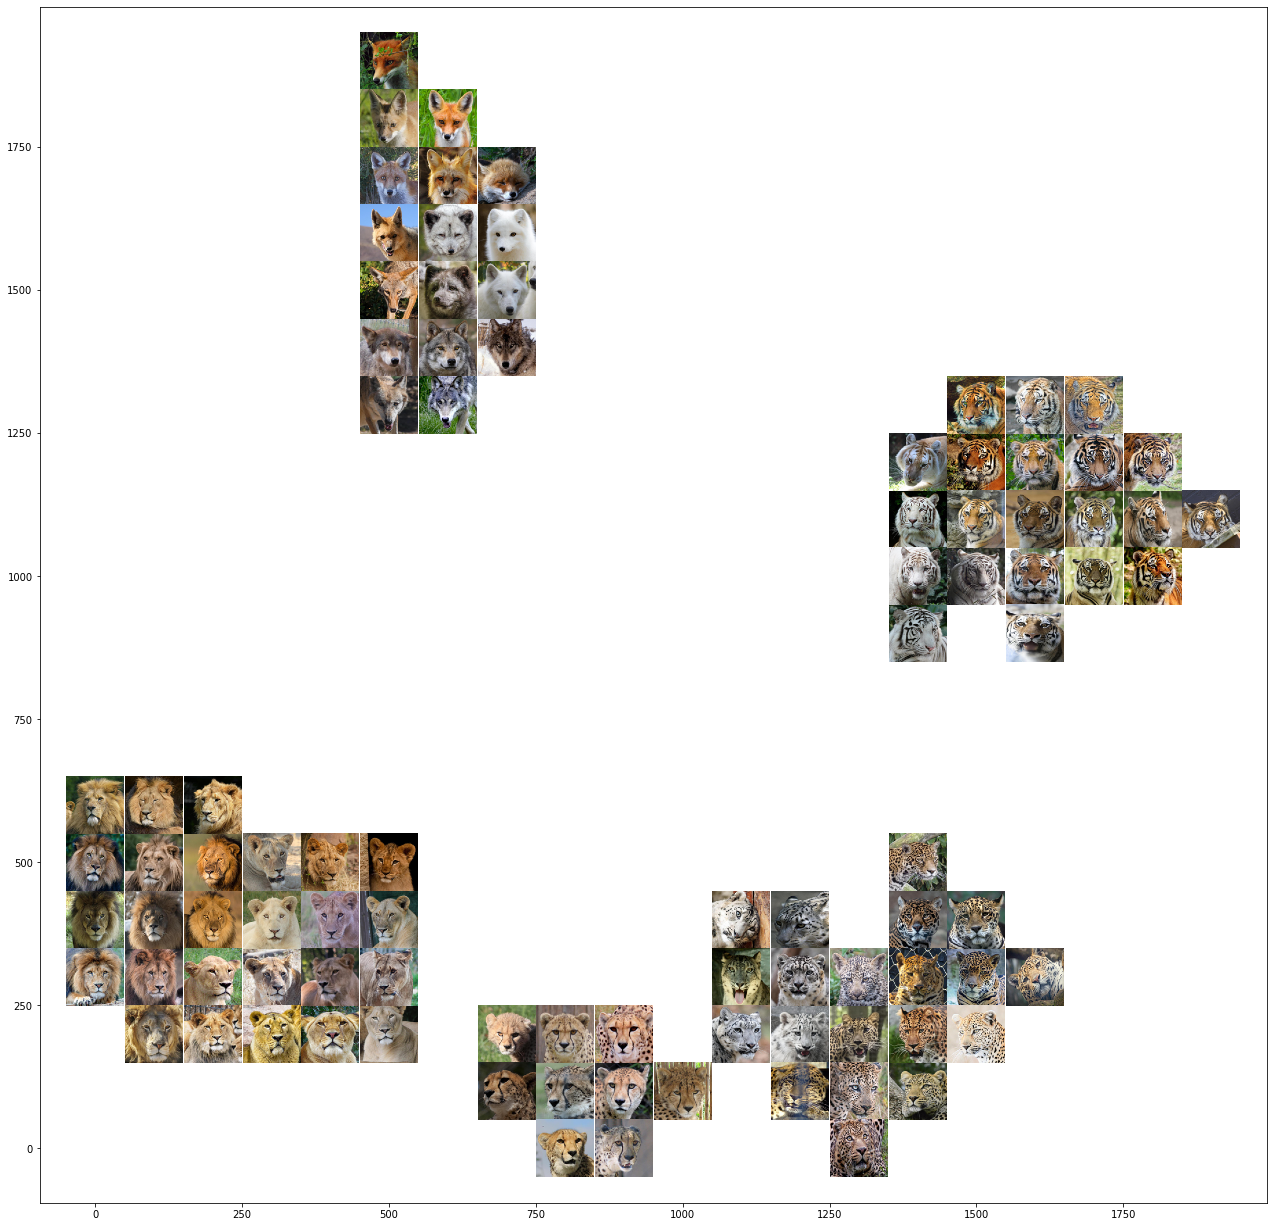

In [32]:
def tsne_to_grid_plotter(x, y, selected_filenames):
    S = 2000
    s = 100
    x = (x - min(x)) / (max(x) - min(x))
    y = (y - min(y)) / (max(y) - min(y))
    x_values = []
    y_values = []
    filename_plot = []
    x_y_dict = {}
    for i, image_path in enumerate(selected_filenames):
        a = np.ceil(x[i] * (S - s))
        b = np.ceil(y[i] * (S - s))
        a = int(a - np.mod(a, s))
        b = int(b - np.mod(b, s))
        if str(a) + "|" + str(b) in x_y_dict:
            continue
        x_y_dict[str(a) + "|" + str(b)] = 1
        x_values.append(a)
        y_values.append(b)
        filename_plot.append(image_path)
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d_format(x_values, y_values, filename_plot, zoom=.58, axis=axis)
    plt.show()
    
tsne_to_grid_plotter(tsne_results[:, 0], tsne_results[:, 1],
                            selected_filenames)